In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import patsy as pt
import pymc3 as pm
import pymc3.math as pmm
import seaborn as sns

from dataclasses import dataclass
from typing import List, Dict, Union
from scipy.stats import bernoulli, expon

print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.11.2


In [2]:
RANDOM_SEED = 242
rng = np.random.default_rng(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

This notebook demonstrates how to implement a Bayesian analysis of A/B test (also called online controlled experiments) results. We implement the models discussed in VWO's [Bayesian A/B Testing Whitepaper](https://vwo.com/downloads/VWO_SmartStats_technical_whitepaper.pdf), and discuss the effect of different prior choices for these models. More advanced topics like early stopping and power analysis are covered in other tutorials.

#### What is A/B testing?

From https://vwo.com/ab-testing/:

> A/B testing (also known as split testing) is a process of showing two variants of the same web page to different segments of website visitors at the same time and comparing which variant drives more conversions.

We further clarify that:

* We can show more than two variants at the same time. We'll be dealing with how to analyse these tests in this notebook as well.
* Exactly what "conversions" means can vary between tests, but two classes of conversions we'll focus on are:
  * Bernoulli conversions - a flag for whether the visitor did the target action or not (e.g. completed at least one purchase).
  * Positive-valued conversions - a real value per visitor (e.g. the dollar revenue, which could also be 0).
  
Where does statistics and PyMC3 come into this? Our underlying assumption is that the different variants of the A/B test cause visitors to behave differently. For example, the rate at which visitors complete a purchase differs depending on the variant. We can observe visitors to collect data on this, but there will be sampling error associated with these observations, we so we need to apply statistics to quantify how confident we are that the variants actually cause different levels of behaviour. This has historically been done with traditional hypothesis testing (see [t-test](https://en.wikipedia.org/wiki/Student%27s_t-test)), but another method is to use Bayesian statistics to incorporate prior distributions and produce a range of outcomes to the question "is there a winning variant" rather than a yes/no.

#### Synthetic data

We'll be using synthetic data for this notebook. In A/B testing, we're concerned with two types of outcomes:

* When the "true" conversion rate of each variant is the same, we don't want to incorrectly identify a "winner" (i.e. we want to minimize false positives).
* When the "true" conversion rate of each variant is different, we want to correctly identify the "winner" (i.e. we want to maximize true positives).

Our synthetic data will align with each of these scenarios.

### Bernoulli Conversions

Let's deal with a simple two-variant A/B test, where the metric of interest is the proportion of users performing an action (e.g. purchase at least one item), a bernoulli conversion. Our variants are called A and B, where A refers to the existing landing page and B refers to the new page we want to test. The outcome that we're doing inference on here is whether B is "better" than A, which is depends on the underlying "true" conversion rates for each variant. We can formulate this as follows:

Let $\theta_A, \theta_B$ be the true conversion rates for variants A and B respectively.

We assume that these true conversion rates cannot be known, and instead they each follow a Beta distribution. The underlying rates are assumed to be independent, since we're splitting out traffic randomly, so the behaviour of one variant would not affect the other: 

$$\theta_A \sim \theta_B \sim \mathrm{Beta}(\alpha, \beta)$$

Now we have our observed data for the duration of the A/B test (the likelihoood distribution): the number of visitors landing on the page `N`, and the number of visitors purchasing at least one item `y`:

$$y_A \sim \mathrm{Binomial}(n = N_A, p = \theta_A), y_B \sim \mathrm{Binomial}(n = N_B, p = \theta_B)$$

With this, we can use PyMC3 to sample from the joint posterior of $\theta_A, \theta_B$. 

You may have noticed that the Beta distribution is the conjugate prior for the Binomial, so we don't need MCMC sampling to estimate the posterior (the exact solution can be found in the VWO paper). We'll still demonstrate how sampling can be done with PyMC3 though, and doing this makes it easier to extend the model with different priors, dependency assumptions, etc.

Finally, remember that our outcome of interest is whether B is better than A. A common measure in practice for whether B is better than is the _relative uplift in conversion rates_, i.e. the percentage difference of $\theta_B$ over $\theta_A$:

$$\mathrm{reluplift}_B = \theta_B / \theta_A - 1$$

We'll implement this model setup in PyMC3 below.

In [3]:
@dataclass
class BetaPrior:
    alpha: float
    beta: float

In [4]:
@dataclass
class BinomialData:
    trials: int
    successes: int

In [5]:
class BetaBinomialTwoVariant:
    def __init__(self, priors: BetaPrior):
        self.priors = priors
    
    def create_model(self, data: List[BinomialData]) -> pm.Model:
        trials = [d.trials for d in data]
        successes = [d.successes for d in data]
        with pm.Model() as model:
            p = pm.Beta("p", alpha=self.priors.alpha, beta=self.priors.beta, shape=2)
            obs = pm.Binomial("y", n=trials, p=p, shape=2, observed=successes)
            reluplift = pm.Deterministic("reluplift_b", p[1] / p[0] - 1)
        return model

Now that we've defined a class that can take a prior and our synthetic data as inputs, our first step is to choose an appropriate prior. There are a few things to consider when doing this in practice, but for the purpose of this notebook we'll focus on the following things:

* We assume that the same Beta prior is set for all variants.
* An _uninformative_ or _weakly informative_ prior occurs when we set low values for `alpha` and `beta`. For example, `alpha = 1, beta = 1` leads to a uniform distribution as a prior. Normally, if we're considering one distribution isolation, setting this prior is a statement that we're not confident about its location and shape. In the context of A/B testing however, we're interested in comparing the posterior distributions of each variant to other variants. If we perform a prior predictive check on this quantity, we'll find that the range of outcomes for the uplift distributions (e.g. the relative uplift of variant B over variant A, `B / A - 1`) is very wide. This means we're implicitly saying that the variants could be very different to each other.
* A strong prior occurs when we set high values for `alpha` and `beta`. Contrary to the point above, setting this prior for each variant would imply that the relative uplift distributions between the variants are thin, i.e. our prior belief is that the variants are not very different from each other.

We illustrate the prior predictive checks below.

#### Prior predictive checks

Note that we can pass in arbitrary values for the observed data in these simulations. PyMC3 will not use that data when sampling from the prior predictive distribution.

In [6]:
weak_prior = BetaBinomialTwoVariant(BetaPrior(alpha=100, beta=100))

In [7]:
with weak_prior.create_model(data=[BinomialData(1, 1), BinomialData(1, 1)]) as model:
    weak_prior_predictive = pm.sample_prior_predictive(samples=10000)

In [8]:
strong_prior = BetaBinomialTwoVariant(BetaPrior(alpha=10000, beta=10000))

In [9]:
with strong_prior.create_model(data=[BinomialData(1, 1), BinomialData(1, 1)]) as model:
    strong_prior_predictive = pm.sample_prior_predictive(samples=10000)

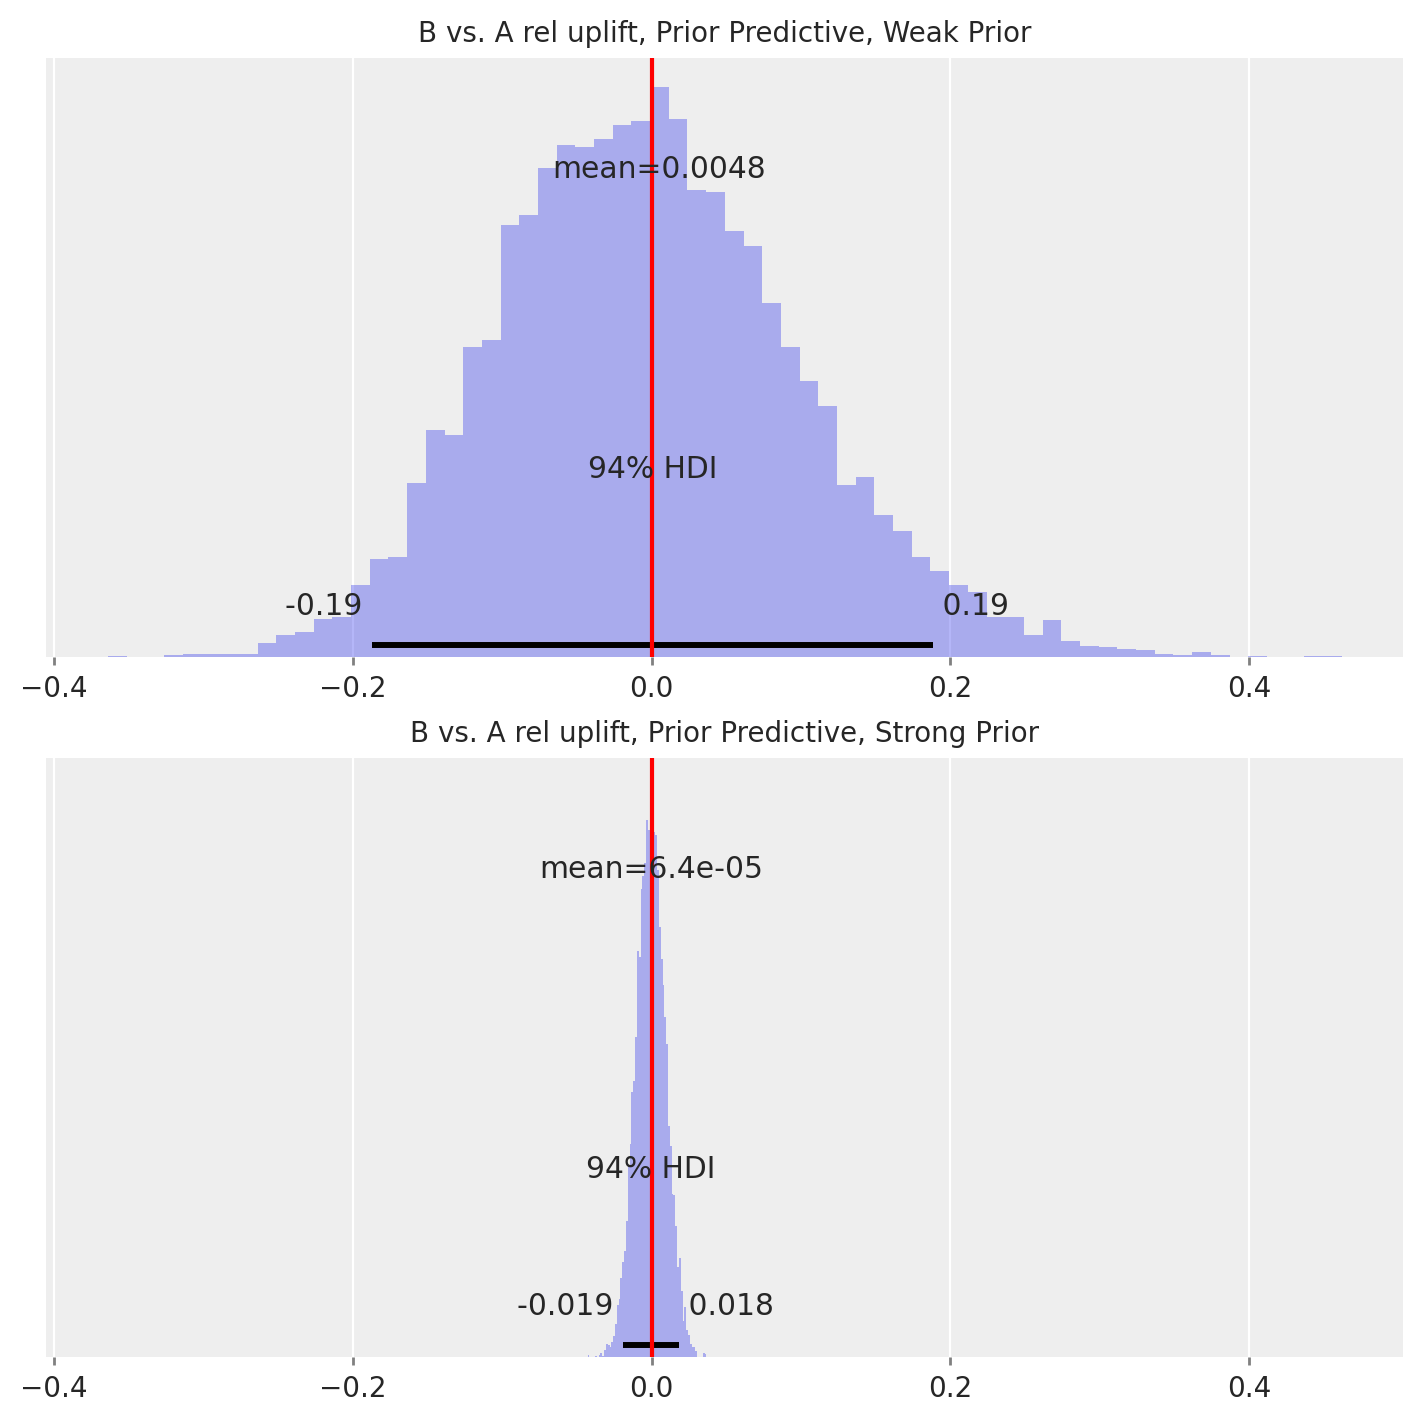

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(7, 7), sharex=True)
az.plot_posterior(weak_prior_predictive['reluplift_b'], textsize=10, ax=axs[0], kind='hist')
axs[0].set_title('B vs. A rel uplift, Prior Predictive, Weak Prior', fontsize=10)
axs[0].axvline(x=0, color='red')
az.plot_posterior(strong_prior_predictive['reluplift_b'], textsize=10, ax=axs[1], kind='hist')
axs[1].set_title('B vs. A rel uplift, Prior Predictive, Strong Prior', fontsize=10)
axs[1].axvline(x=0, color='red')

We can see how the choice of the prior affects our final inference. With the weak prior our 94% HDI for the relative uplift for B over A is [-19%, 20%], whereas it is [-0.85%, 0.85%] with the strong prior.

How we choose these priors in practice depends on broader context of the company running the A/B tests. A strong prior can help guard against false discoveries, but may require much more data for us to detect winning variants when they exist (and more data = more time required running the test). Below we'll walk through the inference results from two different prior choices.

#### Data

Next we'll try passing synthetic data into the model. We generate two datasets: one where the "true" conversion rate of each variant is the same, and one where each variant has a different true rate.

In [11]:
def generate_binomial_data(variants: List[str], true_rates: List[str], samples_per_variant: int = 100000) -> pd.DataFrame:
    data = {}
    for variant, p in zip(variants, true_rates):
        data[variant] = bernoulli.rvs(p, size=samples_per_variant)
    agg = pd.DataFrame(data).aggregate(['count', 'sum']).rename(index={'count': 'trials', 'sum': 'successes'})
    return agg

In [12]:
generate_binomial_data(['A', 'B'], [0.24, 0.24])

,A,B
trials,100000,100000
successes,24211,23931


We'll also write a function to wrap the data generation, sampling, and posterior plots so that we can easily compare the results of both models (strong and weak prior) under both scenarios (same true rate vs. different true rate).

In [13]:
def run_scenario_twovariant(
    variants: List[str],
    true_rates: List[float],
    samples_per_variant: int,
    weak_prior: BetaPrior,
    strong_prior: BetaPrior
) -> None:
    generated = generate_binomial_data(variants, true_rates, samples_per_variant)
    data = [BinomialData(**generated[v].to_dict()) for v in variants]
    weak = BetaBinomialTwoVariant(priors=weak_prior)
    with weak.create_model(data) as model:
        weak_posterior = pm.sample(draws=5000, return_inferencedata=True, cores=1, chains=2)
    strong = BetaBinomialTwoVariant(priors=strong_prior)
    with strong.create_model(data) as model:
        strong_posterior = pm.sample(draws=5000, return_inferencedata=True, cores=1, chains=2)
    
    true_rel_uplift = true_rates[1] / true_rates[0] - 1
    
    fig, axs = plt.subplots(2, 1, figsize=(7, 7), sharex=True)
    az.plot_posterior(weak_posterior.posterior['reluplift_b'], textsize=10, ax=axs[0], kind='hist')
    axs[0].set_title(f'True Rel Uplift = {true_rel_uplift:.1%}, {weak_prior}', fontsize=10)
    axs[0].axvline(x=0, color='red')
    az.plot_posterior(strong_posterior.posterior['reluplift_b'], textsize=10, ax=axs[1], kind='hist')
    axs[1].set_title(f'True Rel Uplift = {true_rel_uplift:.1%}, {strong_prior}', fontsize=10)
    axs[1].axvline(x=0, color='red')
    fig.suptitle('B vs. A Rel Uplift')

#### Scenario 1 - same underlying conversion rates

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 5 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 4 seconds.


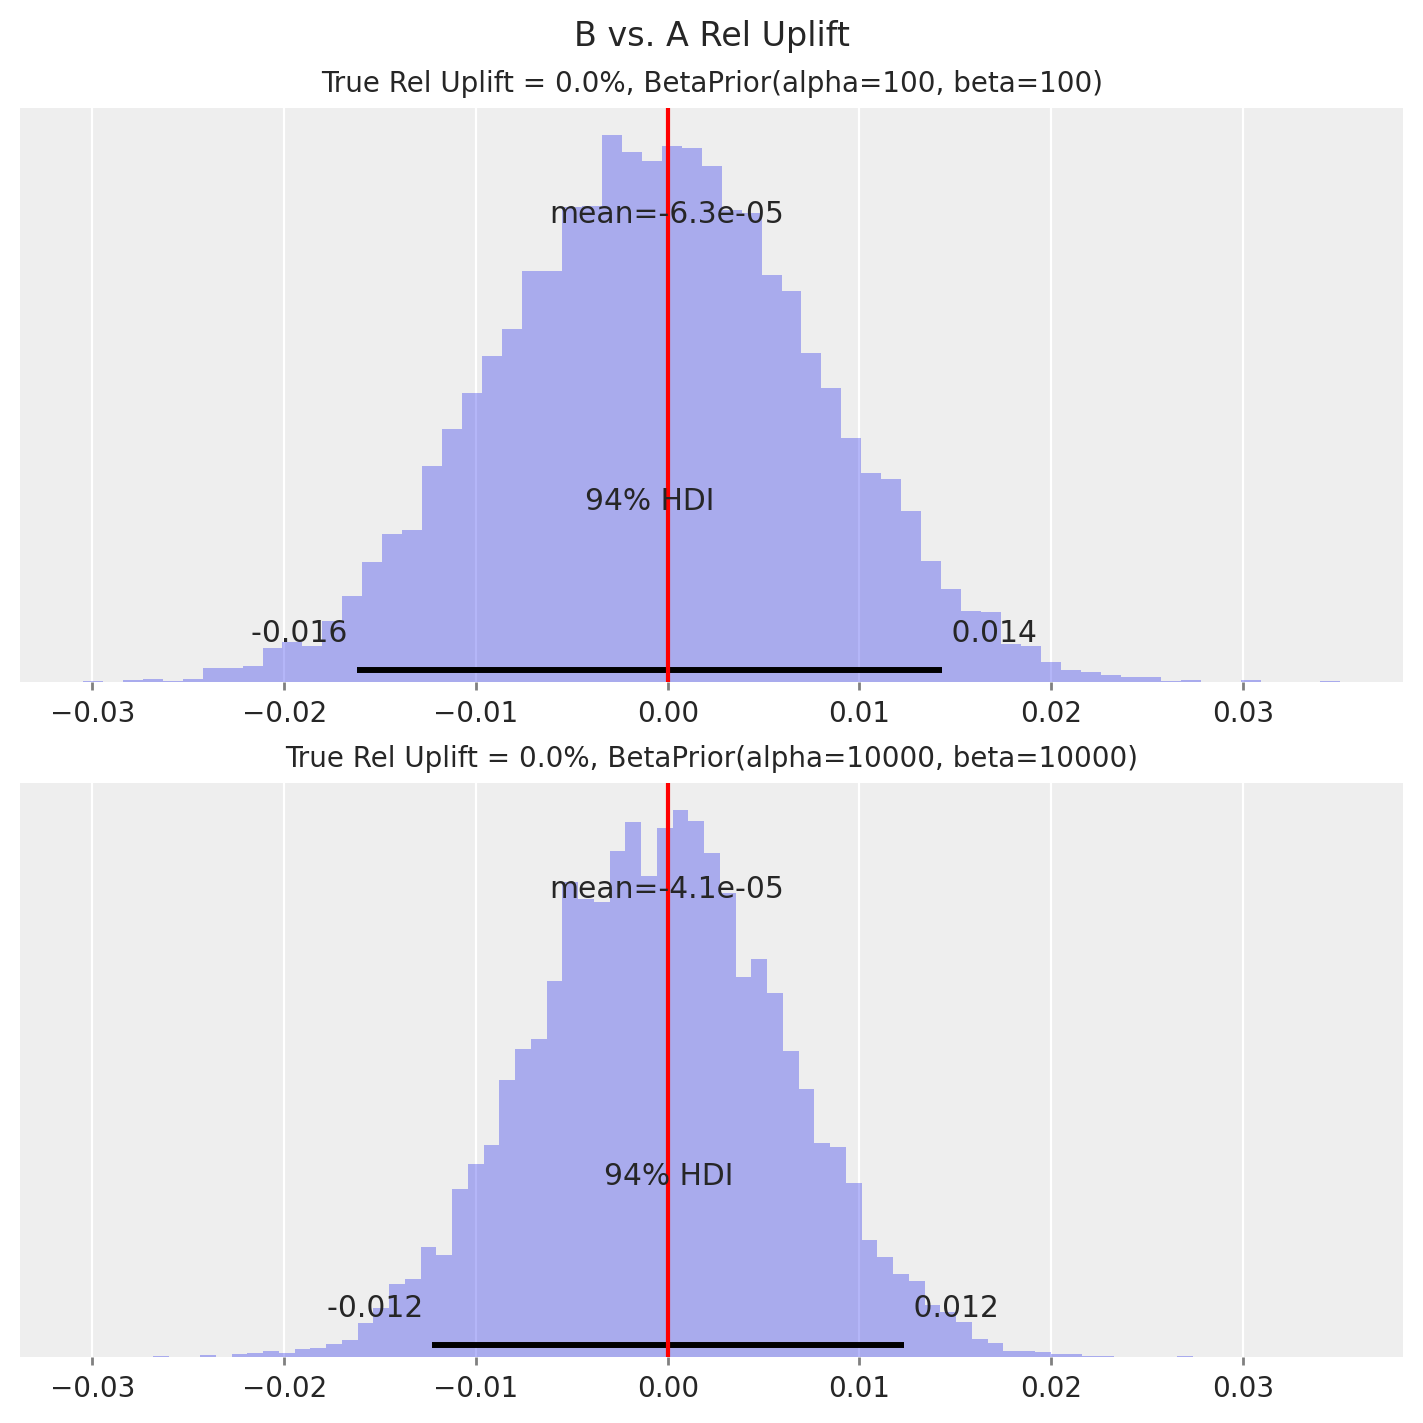

In [14]:
run_scenario_twovariant(
    variants=['A', 'B'],
    true_rates=[0.23, 0.23],
    samples_per_variant=100000,
    weak_prior=BetaPrior(alpha=100, beta=100),
    strong_prior=BetaPrior(alpha=10000, beta=10000)
)

* In both cases, the true rate of 0 lies within the 94% HDI.

#### Scenario 2 - different underlying rates

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 5 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 5 seconds.


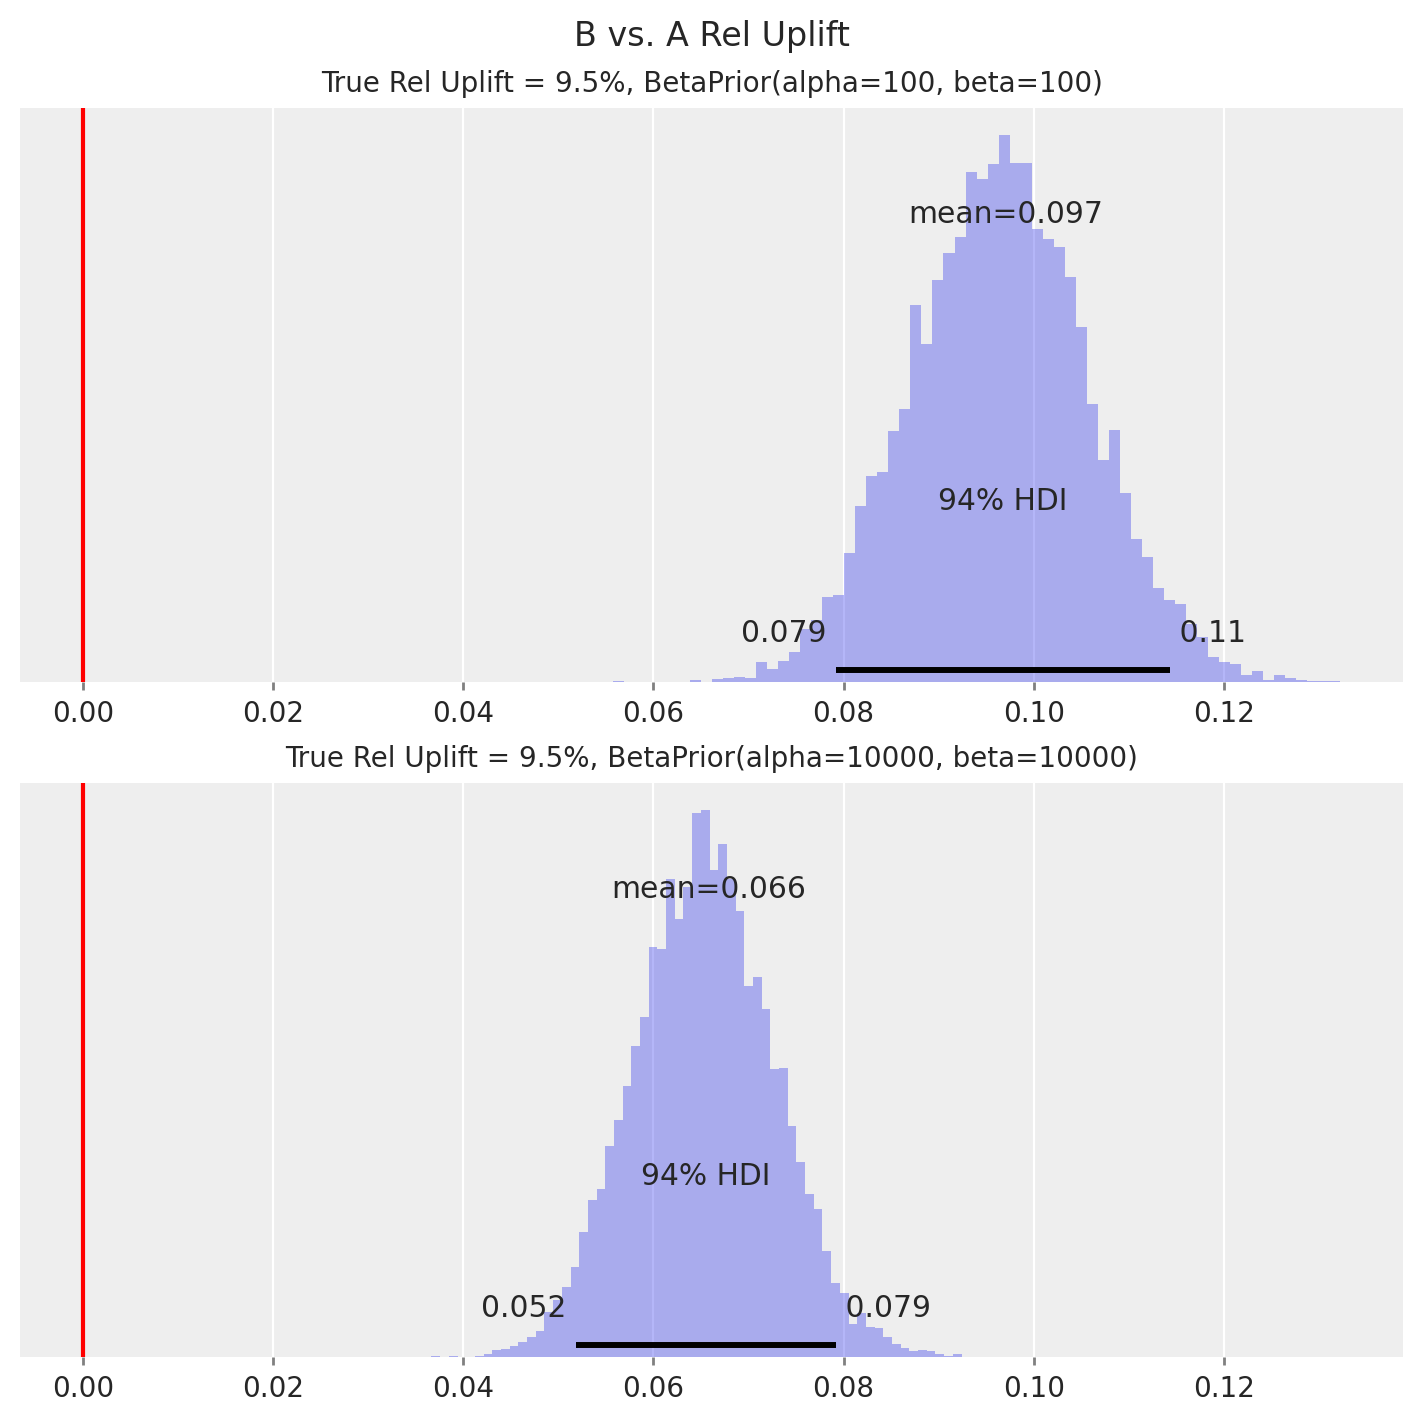

In [15]:
run_scenario_twovariant(
    variants=['A', 'B'],
    true_rates=[0.21, 0.23],
    samples_per_variant=100000,
    weak_prior=BetaPrior(alpha=100, beta=100),
    strong_prior=BetaPrior(alpha=10000, beta=10000)
)

* In both cases, the posterior relative uplift distribution suggests that B has a higher conversion rate than A (a true discovery).
* However, for the model with the strong prior, the effect of the prior outweighs the effect of the observed data, so our central estimate of the relative difference is conservative (and understated). We would need much more data for our inference to get closer to the true difference of 9.5%.

The above examples demonstrate how to calculate perform A/B testing analysis for a two-variant test with the simple Beta-Binomial model, and the benefits and disadvantages of choosing a weak vs. strong prior. In the next section we provide a guide for handling a multi-variant ("A/B/n") test.

### Generalising to multi-variant tests 

We'll continue using Bernoulli conversions and the Beta-Binomial model in this section for simplicity. The focus is on how to analyse tests with 3 or more variants - e.g. instead of just having one different landing page to test, we have multiple ideas we want to test at once. How can we tell if there's a winner amongst all of them?

There are two main approaches we can take here:

1. Take A as the 'control'. Compare the other variants (B, C, etc.) against A, one at a time.
2. For each variant, compare against the `max()` of the other variants. This is also the approach taken in the VWO paper.

Approach 1 is intuitive to most people, and is easily explained. But what if there are two variants that both beat the control, and we want to know which one is better? We can't make that inference with the individual uplift distributions. Approach 2 does handle this case - it effectively tries to find whether there is a clear winner or clear loser(s) amongst all the variants.

We'll implement the model setup for both approaches below, cleaning up our code from before so that it generalises to the `n` variant case. Note that we can also re-use this model for the 2-variant case.

In [16]:
class BetaBinomial:
    def __init__(self, priors: BetaPrior):
        self.priors = priors
    
    def create_model(self, data: List[BinomialData], comparison_method) -> pm.Model:
        num_variants = len(data)
        trials = [d.trials for d in data]
        successes = [d.successes for d in data]
        with pm.Model() as model:
            p = pm.Beta("p", alpha=self.priors.alpha, beta=self.priors.beta, shape=num_variants)
            y = pm.Binomial("y", n=trials, p=p, observed=successes, shape=num_variants)
            reluplift = []
            for i in range(num_variants):
                if comparison_method == 'compare_to_control':
                    comparison = p[0]
                elif comparison_method == 'best_of_rest':
                    others = [p[j] for j in range(num_variants) if j != i]
                    if len(others) > 1:
                        comparison = pmm.maximum(*others)
                    else:
                        comparison = others[0]
                else:
                    raise ValueError(f"comparison method {comparison_method} not recognised.")
                reluplift.append(pm.Deterministic(f"reluplift_{i}", p[i] / comparison - 1))
        return model

In [17]:
def run_scenario_bernoulli(
    variants: List[str],
    true_rates: List[float],
    samples_per_variant: int,
    priors: BetaPrior,
    comparison_method: str
) -> None:
    generated = generate_binomial_data(variants, true_rates, samples_per_variant)
    data = [BinomialData(**generated[v].to_dict()) for v in variants]
    with BetaBinomial(priors).create_model(data=data, comparison_method=comparison_method) as model:
        trace = pm.sample(draws=5000, return_inferencedata=True, chains=2, cores=1)
    
    n_plots = len(variants)
    fig, axs = plt.subplots(nrows=n_plots, ncols=1, figsize=(3*n_plots, 7), sharex=True)
    for i, variant in enumerate(variants):
        if i == 0 and comparison_method == 'compare_to_control':
            axs[i].set_yticks([])
        else:
            az.plot_posterior(trace.posterior[f'reluplift_{i}'], textsize=10, ax=axs[i], kind='hist')
        axs[i].set_title(f'Rel Uplift {variant}, True Rate = {true_rates[i]:.2%}', fontsize=10)
        axs[i].axvline(x=0, color='red')
    fig.suptitle(f'Method {comparison_method}, {priors}')

We generate data where variants B and C are well above A, but quite close to each other:

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 5 seconds.


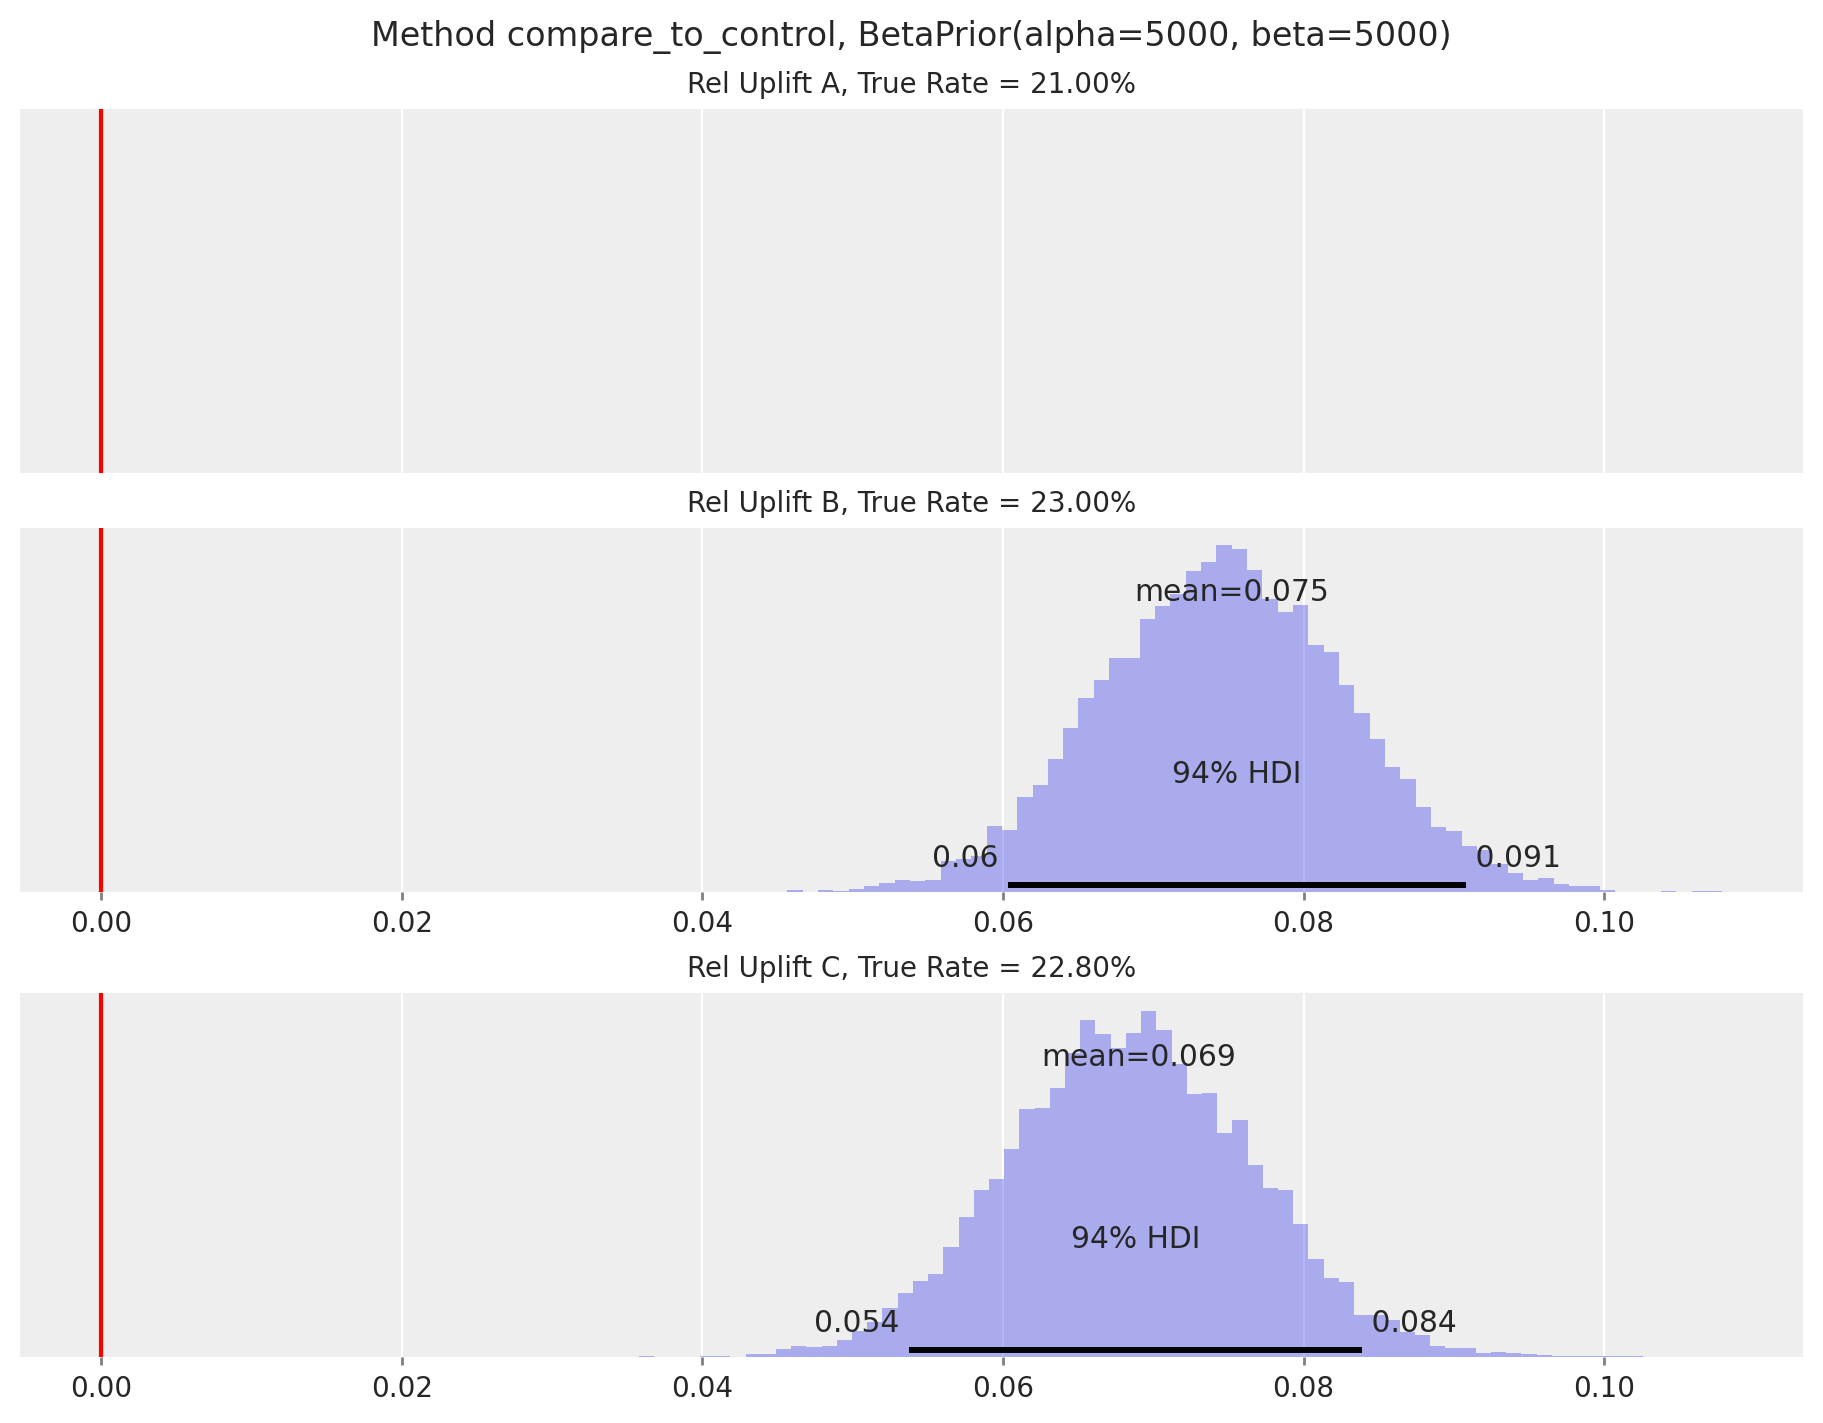

In [18]:
run_scenario_bernoulli(
    variants=['A', 'B', 'C'],
    true_rates=[0.21, 0.23, 0.228],
    samples_per_variant=100000,
    priors=BetaPrior(alpha=5000, beta=5000),
    comparison_method='compare_to_control'
)

* The relative uplift posteriors for both B and C show that they are clearly better than A, by roughly 7% relative.
* However, we can't infer whether there is a winner between B and C.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 5 seconds.


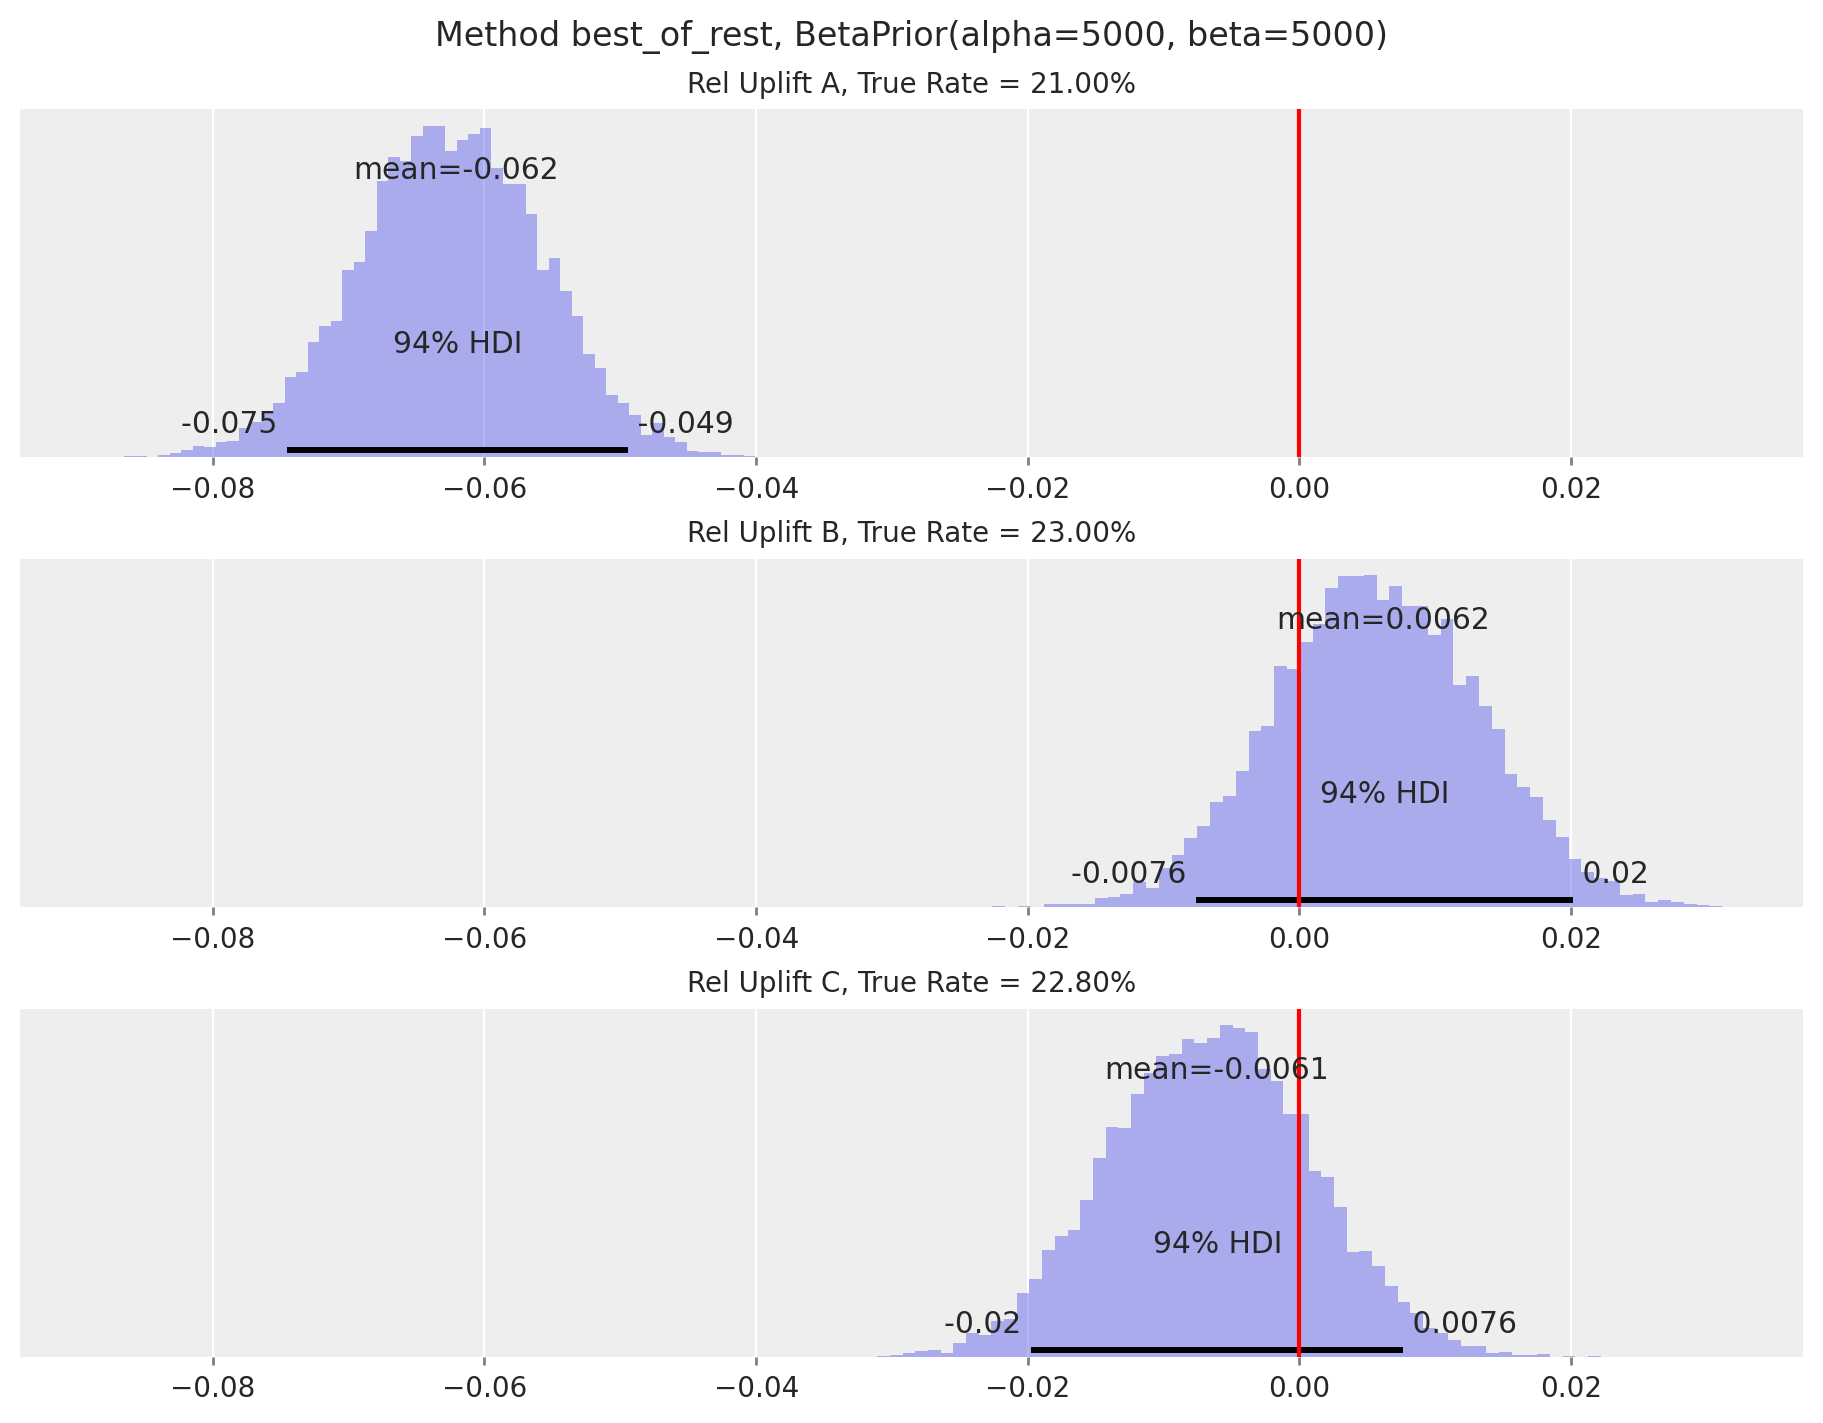

In [19]:
run_scenario_bernoulli(
    variants=['A', 'B', 'C'],
    true_rates=[0.21, 0.23, 0.228],
    samples_per_variant=100000,
    priors=BetaPrior(alpha=5000, beta=5000),
    comparison_method='best_of_rest'
)

* The uplift plot for A tells us that it's a clear loser compared to variants B and C.
* The uplift plots for B and C tell us that we can't yet call a clear winner between the two variants. We'd need a larger sample size to detect the 23% vs 22.8% conversion rate difference.
* Note that the relative uplift calculations for B and C are effectively ignoring variant A. This is because, say, when we are calculating `reluplift` for B, the maximum of the other variants will likely be variant C. Similarly when we are calculating `reluplift` for C, it is likely being compared to B. This means we can't directly say what the uplift of these variants is over the loser, variant A. Instead, we'd have to look at the outcome of "how much worse is A compared to the other two variants", which we can get from the relative uplift distribution of A.

### Value Conversions

Now what if we wanted to compare the variants in terms of how much revenue they generate, and/or estimate how much additional revenue a winning variant brings? We can't use a Beta-Binomial model for this, as the possible values for each visitor are now in the range `[0, Inf)`. The model proposed in the VWO paper is as follows:

The revenue generated by an individual visitor is `revenue = probability of paying at all * mean amount spent when paying`:

$$\mathrm{Revenue}_i = \mathrm{Bernoulli}()_i * \mathrm{Exponential}()_i$$

We can re-use our Beta-Binomial model from before to model the Bernoulli conversions. For the mean amount spent when paying, the rate parameter of the exponential distribution is positive and real-valued, so we can use, say, a Gamma distribution to as a prior. The Gamma distribution is actually the conjugate prior for an Exponential likelihood. So in a two-variant test, the setup is:

$$\theta_A \sim \theta_B \sim \mathrm{Beta}(\alpha_1, \beta_1)$$
$$\lambda_A \sim \lambda_B \sim \mathrm{Gamma}(\alpha_2, \beta_2)$$
$$c_A \sim \mathrm{Binomial}(N_A, \theta_A), c_B \sim \mathrm{Binomial}(N_B, \theta_B)$$
$$\bar{r_A}|c_A = 1 \sim \mathrm{Exponential}(\lambda_A), \bar{r_B}|c_B = 1 \sim \mathrm{Exponential}(\lambda_B)$$
$$\mu_A = \theta_A * \dfrac{1}{\lambda_A}, \mu_B = \theta_B * \dfrac{1}{\lambda_B}$$
$$\mathrm{reluplift}_B = \mu_B / \mu_A - 1$$

$\mu$ here represents the average revenue per visitor, including those who don't make a purchase. This is the best way to capture the overall revenue effect - some variants may increase the average sales value, but reduce the proportion of visitors that pay at all (e.g. promoting more expensive items on the landing page).

Below we put the model setup into code and perform prior predictive checks.

In [20]:
@dataclass
class GammaPrior:
    alpha: float
    beta: float

In [21]:
@dataclass
class RevenueData:
    visitors: int
    purchased: int
    total_revenue: float

In [22]:
class RevenueModel:
    def __init__(self, conversion_rate_prior: BetaPrior, mean_purchase_prior: GammaPrior):
        self.conversion_rate_prior = conversion_rate_prior
        self.mean_purchase_prior = mean_purchase_prior
    
    def create_model(self, data: List[RevenueData], comparison_method: str) -> pm.Model:
        num_variants = len(data)
        visitors = [d.visitors for d in data]
        purchased = [d.purchased for d in data]
        mean_purchase = [d.total_revenue / d.purchased for d in data]
        
        with pm.Model() as model:
            theta = pm.Beta("theta", alpha=self.conversion_rate_prior.alpha, beta=self.conversion_rate_prior.beta, shape=num_variants)
            lam = pm.Gamma("lam", alpha=self.mean_purchase_prior.alpha, beta=self.mean_purchase_prior.beta, shape=num_variants)
            converted = pm.Binomial("converted", n=visitors, p=theta, observed=purchased, shape=num_variants)
            mean_given_converted = pm.Exponential("mean_given_converted", lam=lam, observed=mean_purchase, shape=num_variants)
            revenue_per_visitor = pm.Deterministic("revenue_per_visitor", theta * (1 / lam))
            reluplift = []
            for i in range(num_variants):
                if comparison_method == 'compare_to_control':
                    comparison = revenue_per_visitor[0]
                elif comparison_method == 'best_of_rest':
                    others = [revenue_per_visitor[j] for j in range(num_variants) if j != i]
                    if len(others) > 1:
                        comparison = pmm.maximum(*others)
                    else:
                        comparison = others[0]
                else:
                    raise ValueError(f"comparison method {comparison_method} not recognised.")
                reluplift.append(pm.Deterministic(f"reluplift_{i}", revenue_per_visitor[i] / comparison - 1))
        return model

In [23]:
c_prior = BetaPrior(alpha=5000, beta=5000)
mp_prior = GammaPrior(alpha=5000, beta=5000)

In [24]:
data = [
    RevenueData(visitors=1, purchased=1, total_revenue=1),
    RevenueData(visitors=1, purchased=1, total_revenue=1),
]

In [25]:
with RevenueModel(c_prior, mp_prior).create_model(data, 'best_of_rest'):
    revenue_prior_predictive = pm.sample_prior_predictive(samples=10000)

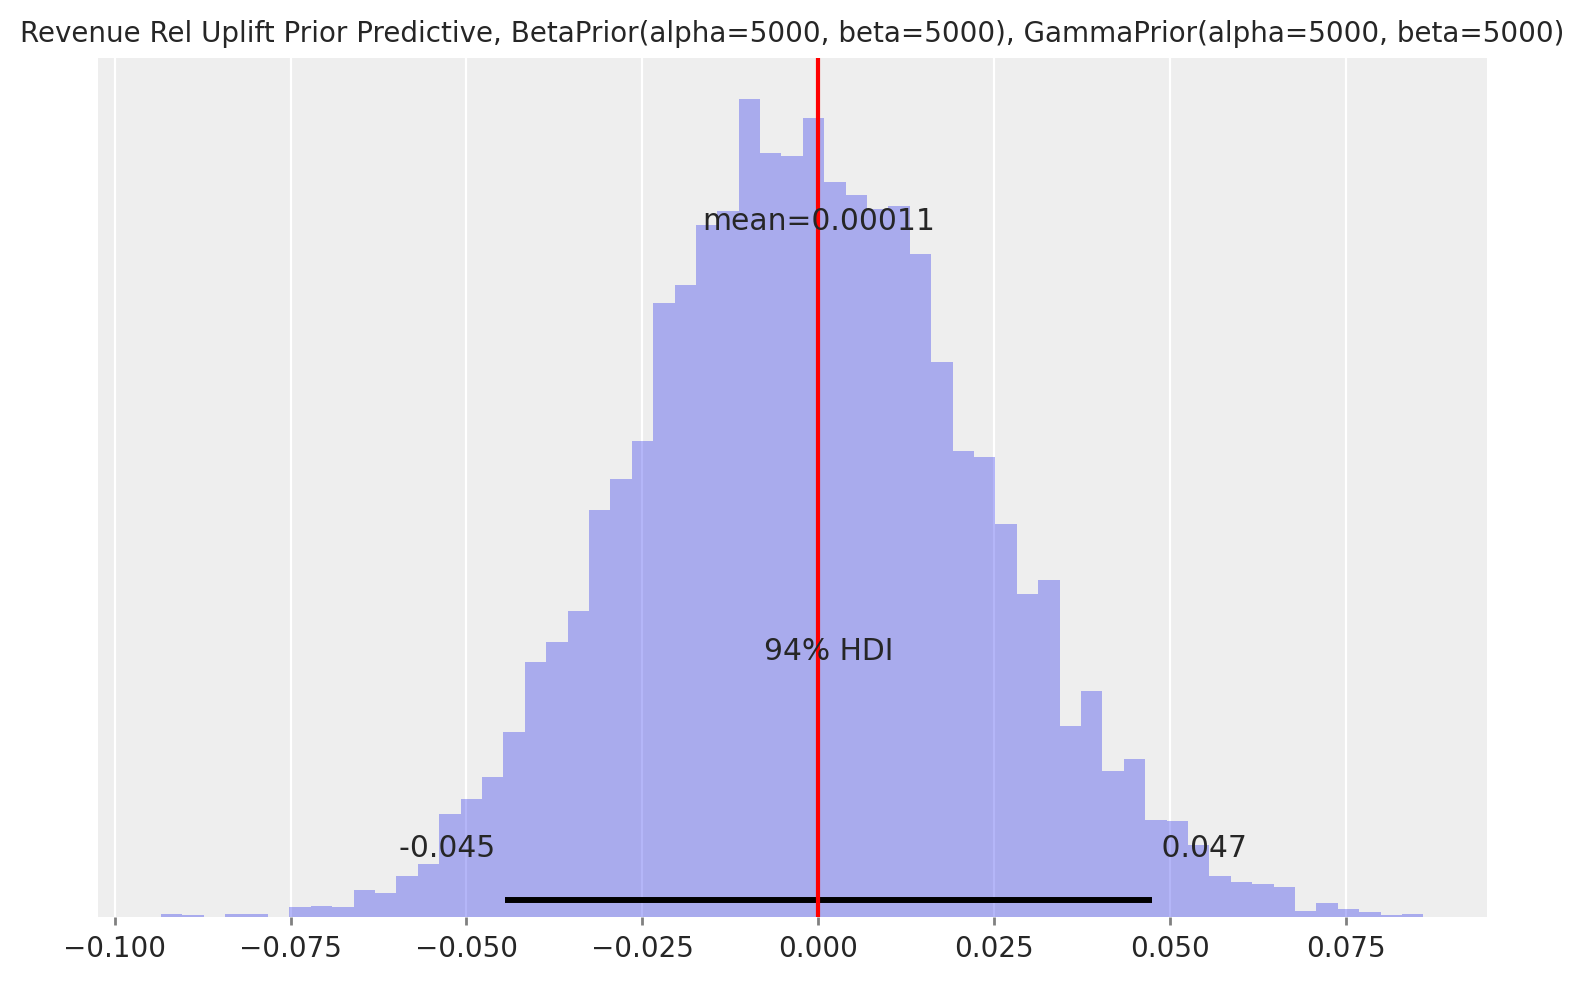

In [26]:
fig, ax = plt.subplots()
az.plot_posterior(revenue_prior_predictive['reluplift_1'], textsize=10, ax=ax, kind='hist')
ax.set_title(f'Revenue Rel Uplift Prior Predictive, {c_prior}, {mp_prior}', fontsize=10)
ax.axvline(x=0, color='red')

Similar to the model for Bernoulli conversions, the width of the prior predictive uplift distribution depends on the strength of our prior. The strength of the prior is typically chosen based on the individual company's current traffic, conversion rates, and trying to balance finding true discoveries quickly vs. minimizing false discoveries.

Now we generate synthetic data for the model. We'll generate three scenarios:

* Same propensity to purchase and same mean purchase value.
* Lower propensity to purchase and higher mean purchase value, but overall same revenue per visitor.
* Higher propensity to purchase and higher mean purchase value, and overall higher revenue per visitor.

There are more combinations of impacts on `propensity to purchase` and `mean purchase value`, but their outcomes should be similar to one of the three above.

In [27]:
def generate_revenue_data(
    variants: List[str],
    true_conversion_rates: List[float],
    true_mean_purchase: List[float],
    samples_per_variant: int
) -> pd.DataFrame:
    converted = {}
    mean_purchase = {}
    for variant, p, mp in zip(variants, true_conversion_rates, true_mean_purchase):
        converted[variant] = bernoulli.rvs(p, size=samples_per_variant)
        mean_purchase[variant] = expon.rvs(scale=mp, size=samples_per_variant)
    converted = pd.DataFrame(converted)
    mean_purchase = pd.DataFrame(mean_purchase)
    revenue = converted * mean_purchase
    agg = pd.concat([
        converted.aggregate(['count', 'sum']).rename(index={'count': 'visitors', 'sum': 'purchased'}),
        revenue.aggregate(['sum']).rename(index={'sum': 'total_revenue'})
    ])
    return agg

In [28]:
def run_scenario_value(
    variants: List[str],
    true_conversion_rates: List[float],
    true_mean_purchase: List[float],
    samples_per_variant: int,
    conversion_rate_prior: BetaPrior,
    mean_purchase_prior: GammaPrior,
    comparison_method: str
) -> None:
    generated = generate_revenue_data(variants, true_conversion_rates, true_mean_purchase, samples_per_variant)
    data = [RevenueData(**generated[v].to_dict()) for v in variants]
    with RevenueModel(conversion_rate_prior, mean_purchase_prior).create_model(data=data, comparison_method=comparison_method):
        trace = pm.sample(draws=5000, return_inferencedata=True, chains=2, cores=1)
    
    n_plots = len(variants)
    fig, axs = plt.subplots(nrows=n_plots, ncols=1, figsize=(3*n_plots, 7), sharex=True)
    for i, variant in enumerate(variants):
        if i == 0 and comparison_method == 'compare_to_control':
            axs[i].set_yticks([])
        else:
            az.plot_posterior(trace.posterior[f'reluplift_{i}'], textsize=10, ax=axs[i], kind='hist')
        true_rpv = true_conversion_rates[i] * true_mean_purchase[i]
        axs[i].set_title(f'Rel Uplift {variant}, True Rate = {true_rpv:.2f}', fontsize=10)
        axs[i].axvline(x=0, color='red')
    fig.suptitle(f'Method {comparison_method}, {conversion_rate_prior}, {mean_purchase_prior}')

#### Scenario 1 - same underlying purchase rate and mean purchase value

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [lam, theta]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 6 seconds.


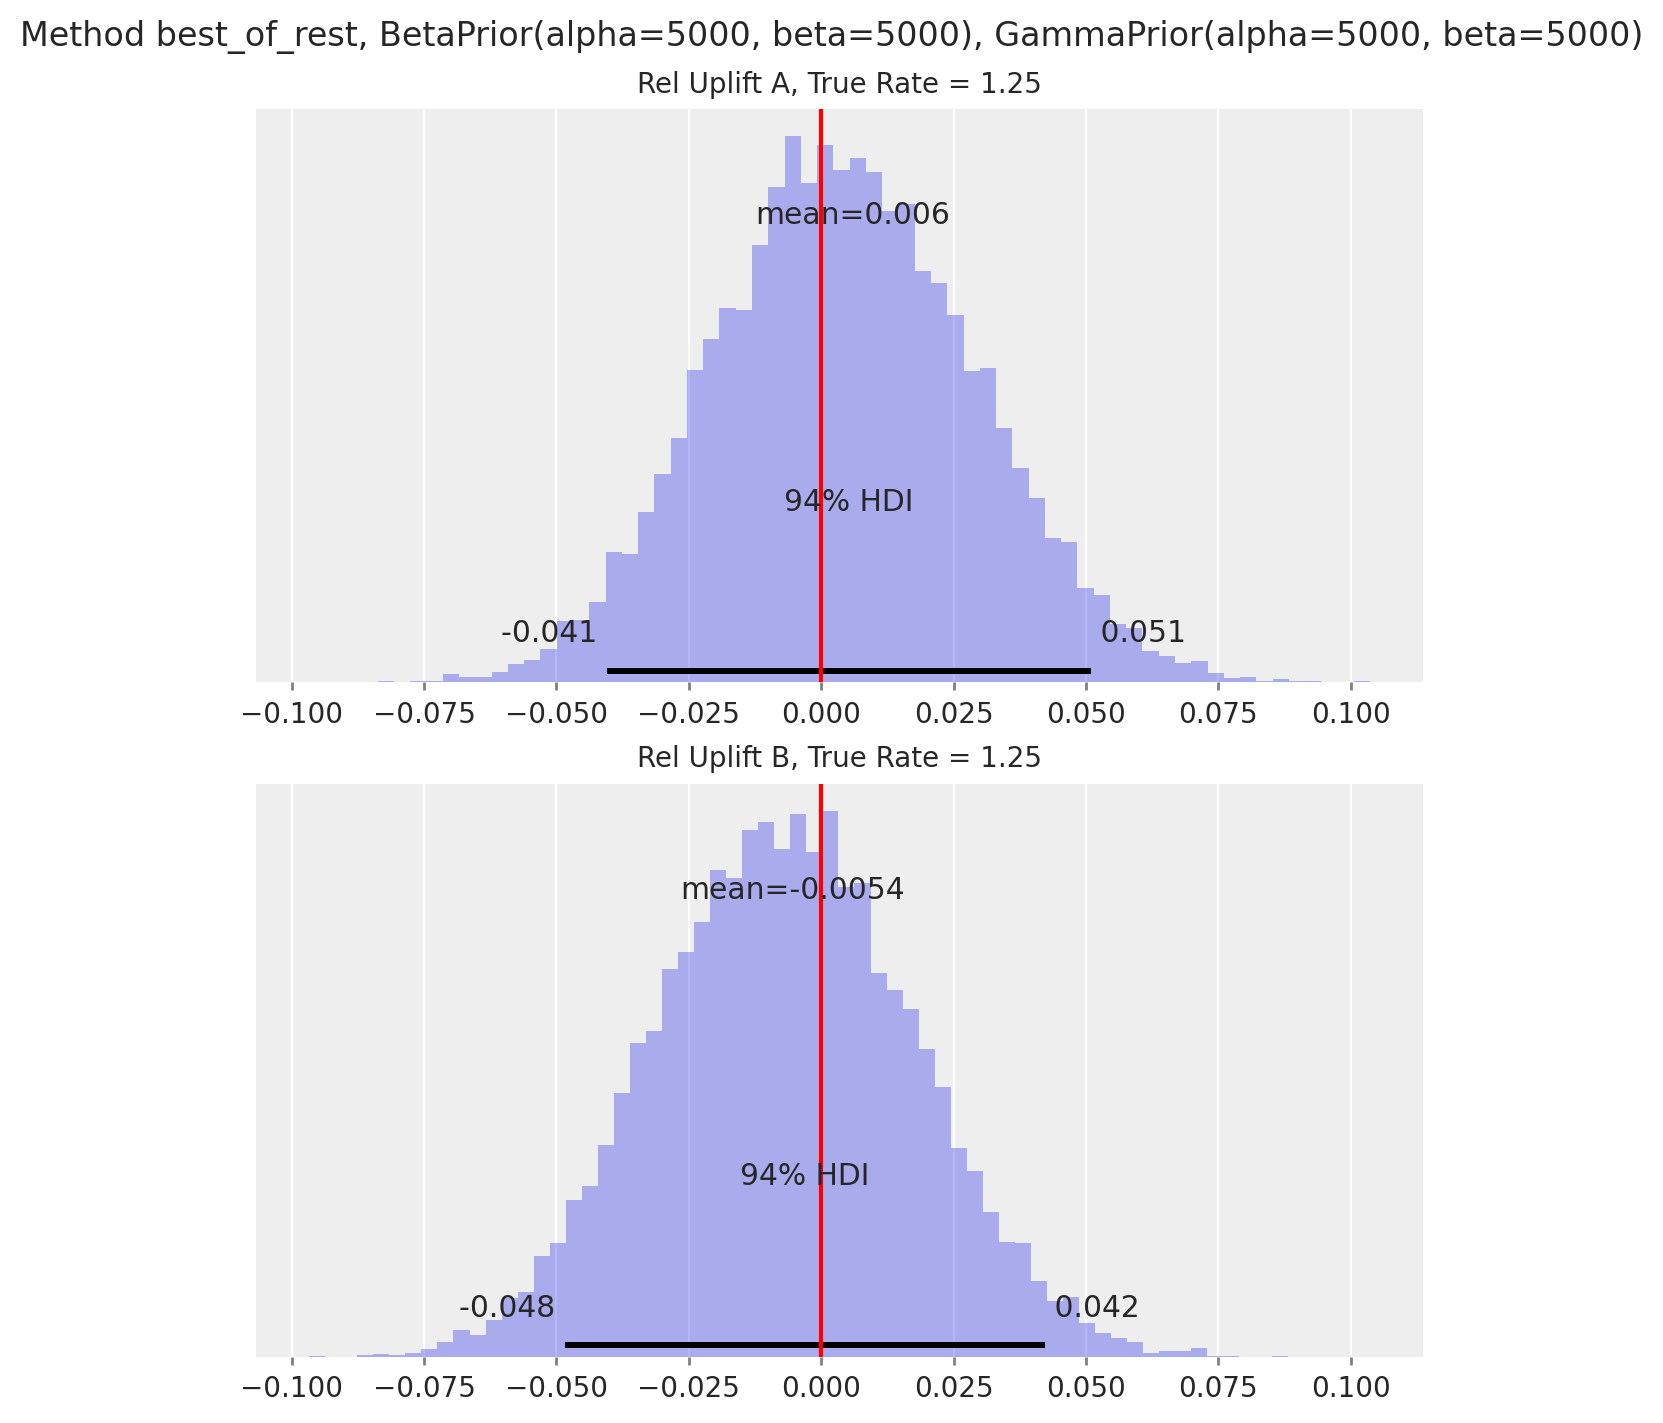

In [29]:
run_scenario_value(
    variants=['A', 'B'],
    true_conversion_rates=[0.05, 0.05],
    true_mean_purchase=[25, 25],
    samples_per_variant=100000,
    conversion_rate_prior=BetaPrior(alpha=5000, beta=5000),
    mean_purchase_prior=GammaPrior(alpha=5000, beta=5000),
    comparison_method='best_of_rest'
)

#### Scenario 2 - lower purchase rate, higher mean purchase, same overall revenue per visitor

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [lam, theta]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 7 seconds.


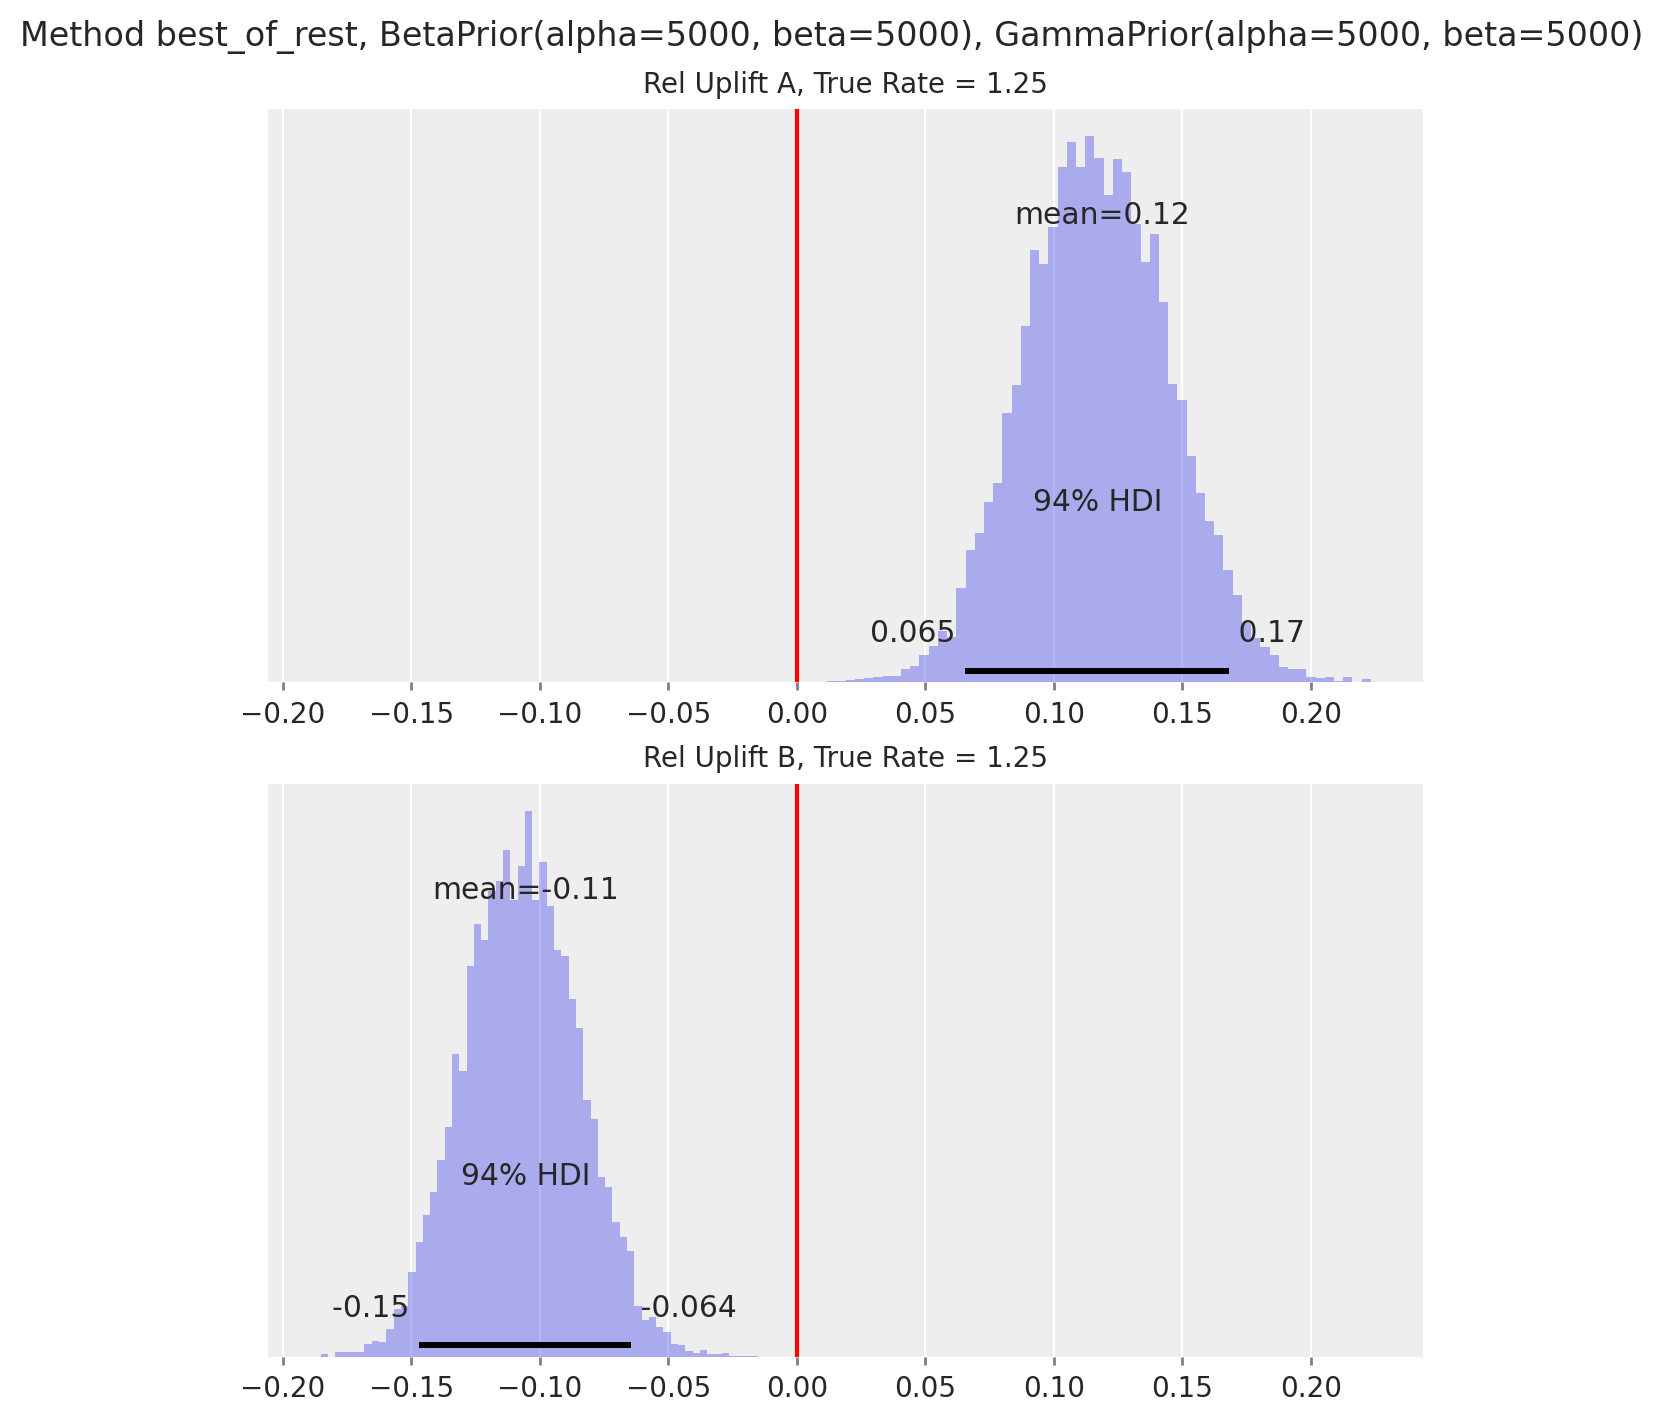

In [30]:
run_scenario_value(
    variants=['A', 'B'],
    true_conversion_rates=[0.05, 0.04],
    true_mean_purchase=[25, 31.25],
    samples_per_variant=100000,
    conversion_rate_prior=BetaPrior(alpha=5000, beta=5000),
    mean_purchase_prior=GammaPrior(alpha=5000, beta=5000),
    comparison_method='best_of_rest'
)

#### Scenario 3 - Higher propensity to purchase and mean purchase value

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [lam, theta]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 6 seconds.


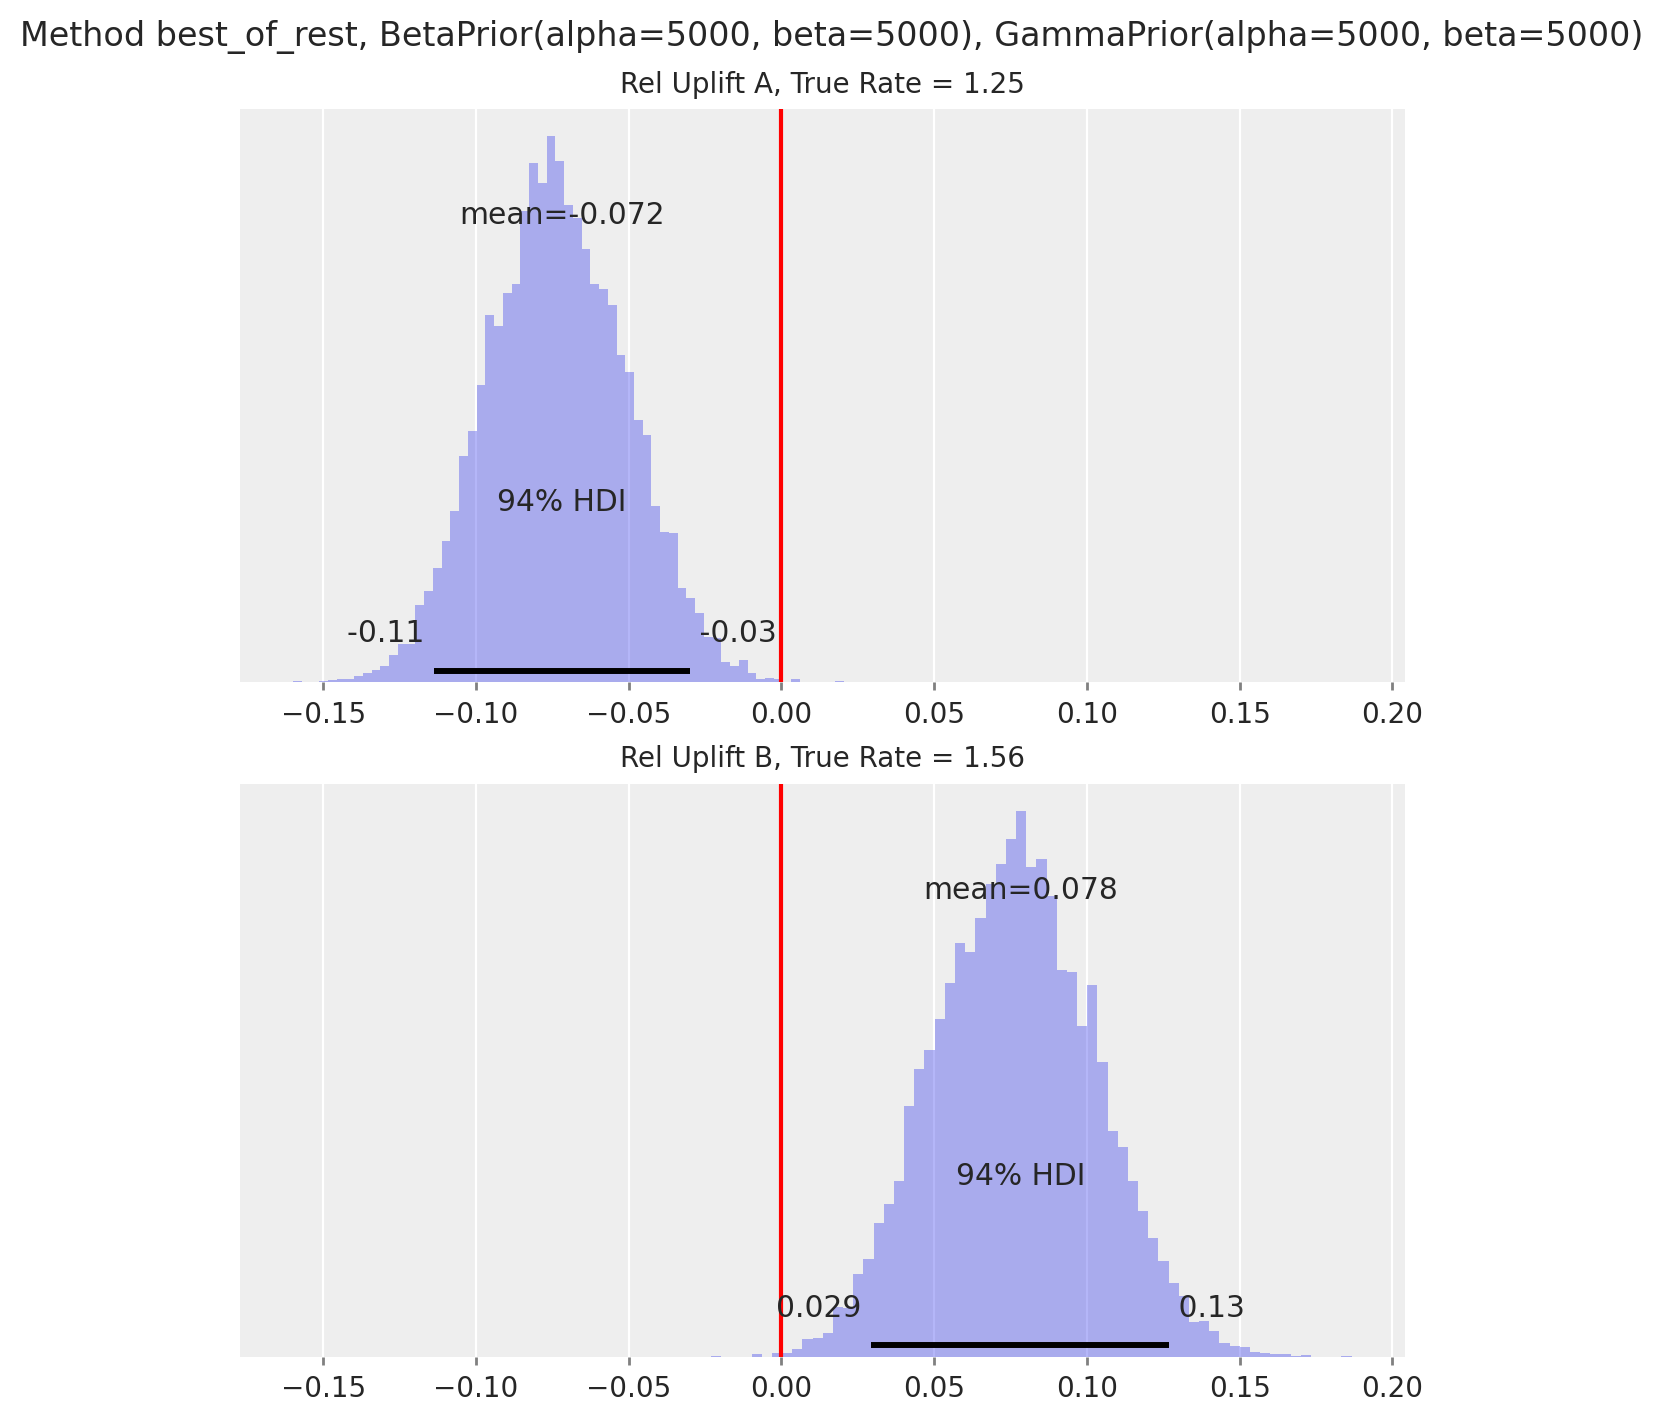

In [31]:
run_scenario_value(
    variants=['A', 'B'],
    true_conversion_rates=[0.05, 0.06],
    true_mean_purchase=[25, 26],
    samples_per_variant=100000,
    conversion_rate_prior=BetaPrior(alpha=5000, beta=5000),
    mean_purchase_prior=GammaPrior(alpha=5000, beta=5000),
    comparison_method='best_of_rest'
)